In [ ]:
import os
import pickle
import tensorflow as tf
import numpy as np
from sklearn.model_selection import StratifiedKFold
from collections import Counter
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [ ]:
# Define parameters
IMAGE_SIZE = (224, 224)  # Resize images to this size
BATCH_SIZE = 32
K_FOLDS = 5
EPOCHS = 20
CHECKPOINT_PATH = "/content/drive/MyDrive/Model Checkpoints/best_model.keras"

# Path to the dataset
DATASET_PATH = "/content/drive/MyDrive/Image Data/Augmented Control Images"

In [ ]:
# Function for loading data
def load_data(dataset_path):
    images = []
    labels = []
    label_map = {"day0": 0, "day2": 1, "day5": 2, "day6": 3, "day8": 4, "day10": 5}

    for mouse_folder in os.listdir(dataset_path):
        mouse_path = os.path.join(dataset_path, mouse_folder)
        if not os.path.isdir(mouse_path):
            continue

        for day_folder in os.listdir(mouse_path):
            day_path = os.path.join(mouse_path, day_folder, "control")
            if not os.path.isdir(day_path):
                continue

            label = label_map[day_folder]
            for img_file in os.listdir(day_path):
                img_path = os.path.join(day_path, img_file)
                images.append(img_path)
                labels.append(label)

    return np.array(images), np.array(labels)

In [ ]:
# Load data
images, labels = load_data(DATASET_PATH)

# Shuffle the data
indices = np.arange(len(images))
np.random.shuffle(indices)
images = images[indices]
labels = labels[indices]

# Print total data statistics
print(f"Total images: {len(images)}")
print(f"Class distribution: {Counter(labels)}")

Total images: 1060
Class distribution: Counter({2: 180, 3: 180, 0: 180, 1: 180, 5: 180, 4: 160})


In [ ]:
# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
folds = []

for train_idx, val_idx in skf.split(images, labels):
    folds.append((train_idx, val_idx))

# Save folds for reproducibility
folds_path = "/content/drive/MyDrive/saved_folds/folds.npy"

with open(folds_path, 'wb') as f: # Open the file in binary write mode ('wb')
    pickle.dump(folds, f) # Use pickle.dump to save the folds list

print(f"Folds saved to: {folds_path}")

# Print class distribution per fold
for i, (train_idx, val_idx) in enumerate(folds):
    train_labels = labels[train_idx]
    val_labels = labels[val_idx]
    print(f"Fold {i+1}:")
    print(f"  Train class distribution: {Counter(train_labels)}")
    print(f"  Validation class distribution: {Counter(val_labels)}")

Folds saved to: /content/drive/MyDrive/saved_folds/folds.npy
Fold 1:
  Train class distribution: Counter({3: 144, 0: 144, 1: 144, 2: 144, 5: 144, 4: 128})
  Validation class distribution: Counter({2: 36, 1: 36, 5: 36, 0: 36, 3: 36, 4: 32})
Fold 2:
  Train class distribution: Counter({2: 144, 3: 144, 0: 144, 1: 144, 5: 144, 4: 128})
  Validation class distribution: Counter({1: 36, 2: 36, 5: 36, 3: 36, 0: 36, 4: 32})
Fold 3:
  Train class distribution: Counter({2: 144, 3: 144, 1: 144, 5: 144, 0: 144, 4: 128})
  Validation class distribution: Counter({0: 36, 1: 36, 5: 36, 2: 36, 3: 36, 4: 32})
Fold 4:
  Train class distribution: Counter({2: 144, 0: 144, 1: 144, 5: 144, 3: 144, 4: 128})
  Validation class distribution: Counter({3: 36, 1: 36, 0: 36, 5: 36, 2: 36, 4: 32})
Fold 5:
  Train class distribution: Counter({2: 144, 3: 144, 0: 144, 1: 144, 5: 144, 4: 128})
  Validation class distribution: Counter({5: 36, 2: 36, 3: 36, 1: 36, 0: 36, 4: 32})


In [ ]:
# Define the CNN model
def create_cnn_model(input_shape, num_classes):
    model = models.Sequential([
        layers.InputLayer(input_shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
# Create the model for later use
input_shape = IMAGE_SIZE + (3,)  # Assuming RGB images
num_classes = 6
model = create_cnn_model(input_shape, num_classes)

# Print the model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │      12,845,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,939,206 (49.36 MB)

 Trainable params: 12,939,206 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Training and validation loop
histories = []

for fold, (train_idx, val_idx) in enumerate(folds):
    print(f"\nStarting Fold {fold + 1}/{K_FOLDS}")

    # Split data for the current fold
    train_images, val_images = images[train_idx], images[val_idx]
    train_labels, val_labels = labels[train_idx], labels[val_idx]

    # Prepare datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    train_dataset = train_dataset.map(lambda x, y: (tf.image.resize(tf.image.decode_jpeg(tf.io.read_file(x)), IMAGE_SIZE) / 255.0, y))
    train_dataset = train_dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
    val_dataset = val_dataset.map(lambda x, y: (tf.image.resize(tf.image.decode_jpeg(tf.io.read_file(x)), IMAGE_SIZE) / 255.0, y))
    val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    # Create model for the fold
    model = create_cnn_model(input_shape, num_classes)

    # Callbacks
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH, save_best_only=True, monitor='val_accuracy', mode='max')
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

    # Train the model
    history = model.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=EPOCHS,
                        callbacks=[checkpoint_cb, early_stopping_cb])

    # Save history for summary
    histories.append(history.history)

    # Print metrics for the fold
    print(f"Fold {fold + 1} Metrics:")
    print(f"  Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}")
    print(f"  Final Training Accuracy: {max(history.history['accuracy']):.4f}")


Starting Fold 1/5
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 24s 785ms/step - accuracy: 0.1811 - loss: 2.4490 - val_accuracy: 0.1698 - val_loss: 1.7858
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.2166 - loss: 1.7812 - val_accuracy: 0.1698 - val_loss: 1.6913
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.2280 - loss: 1.6285 - val_accuracy: 0.3208 - val_loss: 1.5089
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.3978 - loss: 1.4206 - val_accuracy: 0.5283 - val_loss: 1.1614
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.4798 - loss: 1.2140 - val_accuracy: 0.6038 - val_loss: 1.0747
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.6087 - loss: 1.0690 - val_accuracy: 0.6415 - val_loss: 0.8984
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.6296 - loss: 0.9202 - val_accuracy: 0.7028 - val_loss: 0.7833
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6923 - loss: 0.8293 - val

# **Fold 5 model fine-tuning.**

In [ ]:
# Load the Fold 5 model (final_model.keras) without modifying it
fold5_model_path = "/content/drive/MyDrive/Model Checkpoints/final_model.keras"
model = tf.keras.models.load_model(fold5_model_path)

# Fine-tune the Fold 5 model on the full training dataset
full_train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
full_train_dataset = full_train_dataset.map(lambda x, y: (tf.image.resize(tf.image.decode_jpeg(tf.io.read_file(x)), IMAGE_SIZE) / 255.0, y))
full_train_dataset = full_train_dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Recompile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Save the fine-tuned model to a new file
retrained_model_path = "/content/drive/MyDrive/Model Checkpoints/retrained_model_finetuned.keras"
model.fit(full_train_dataset,
          epochs=EPOCHS,
          callbacks=[
              tf.keras.callbacks.ModelCheckpoint(retrained_model_path, save_best_only=True, monitor='accuracy', mode='max'),
              tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
          ])

print(f"Fine-tuned model saved at: {retrained_model_path}")

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - accuracy: 0.8910 - loss: 0.2895
Epoch 2/20


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.9299 - loss: 0.1988
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9226 - loss: 0.2026
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.9416 - loss: 0.1723
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9270 - loss: 0.2042
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.9541 - loss: 0.1476
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9169 - loss: 0.1953
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.9527 - loss: 0.1532
Epoch 9/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9479 - loss: 0.1694
Epoch 10/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.9500 - loss: 0.1514
Epoch 11/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.9582 - loss: 0.1245
Epoch 12/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.9594 - loss: 0.1304
Epoch 13/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9448 - 

# **Just code for evaluating the results from this onwards.**

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/Model Checkpoints/final_model.keras")

In [ ]:
with open("/content/drive/MyDrive/saved_folds/folds.npy", "rb") as f:
    folds = pickle.load(f)

In [ ]:
def generate_final_summary(histories):
    print("\n================== FINAL SUMMARY ==================")
    for fold, history in enumerate(histories):
        print(f"Fold {fold + 1}:")
        print(f"  Total Epochs Trained: {len(history['accuracy'])}")
        print(f"  Best Validation Accuracy: {max(history['val_accuracy']):.4f}")
        print(f"  Final Training Accuracy: {max(history['accuracy']):.4f}")
        print(f"  Best Validation Loss: {min(history['val_loss']):.4f}")
        print(f"  Best Training Loss: {min(history['loss']):.4f}")
        print("---------------------------------------------------")
    print("===================================================")

In [ ]:
generate_final_summary(histories)


================== FINAL SUMMARY ==================
Fold 1:
  Total Epochs Trained: 19
  Best Validation Accuracy: 0.9151
  Final Training Accuracy: 0.9186
  Best Validation Loss: 0.2810
  Best Training Loss: 0.2353
---------------------------------------------------
Fold 2:
  Total Epochs Trained: 20
  Best Validation Accuracy: 0.9057
  Final Training Accuracy: 0.9092
  Best Validation Loss: 0.3349
  Best Training Loss: 0.2885
---------------------------------------------------
Fold 3:
  Total Epochs Trained: 20
  Best Validation Accuracy: 0.9009
  Final Training Accuracy: 0.9163
  Best Validation Loss: 0.2625
  Best Training Loss: 0.2396
---------------------------------------------------
Fold 4:
  Total Epochs Trained: 20
  Best Validation Accuracy: 0.6509
  Final Training Accuracy: 0.5248
  Best Validation Loss: 0.9788
  Best Training Loss: 1.0930
---------------------------------------------------
Fold 5:
  Total Epochs Trained: 20
  Best Validation Accuracy: 0.9151
  Final Train

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


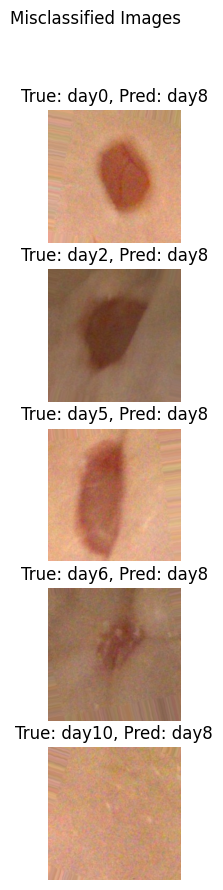

In [ ]:
# Analyzing the worst fold's misclassified images
def display_wrong_predictions(model, val_images, val_labels, class_names, count_per_class=1):
    predictions = model.predict(tf.data.Dataset.from_tensor_slices(val_images).map(
        lambda x: tf.image.resize(tf.image.decode_jpeg(tf.io.read_file(x)), IMAGE_SIZE) / 255.0).batch(BATCH_SIZE))
    predicted_labels = np.argmax(predictions, axis=1)

    wrong_indices = np.where(predicted_labels != val_labels)[0]
    misclassified = []

    for cls in range(len(class_names)):
        cls_indices = [i for i in wrong_indices if val_labels[i] == cls]
        if cls_indices:
            misclassified.append(cls_indices[:count_per_class])

    plt.figure(figsize=(15, 10))
    for i, cls_indices in enumerate(misclassified):
        if cls_indices:
            for j, idx in enumerate(cls_indices):
                img = tf.image.decode_jpeg(tf.io.read_file(val_images[idx])).numpy()
                plt.subplot(len(misclassified), count_per_class, i * count_per_class + j + 1)
                plt.imshow(img)
                plt.title(f"True: {class_names[val_labels[idx]]}, Pred: {class_names[predicted_labels[idx]]}")
                plt.axis("off")

    plt.suptitle("Misclassified Images")
    plt.show()

# Define the fold number
fold_number = 4
train_idx, val_idx = folds[fold_number - 1]
val_images_fold4 = images[val_idx]
val_labels_fold4 = labels[val_idx]

class_names = ["day0", "day2", "day5", "day6", "day8", "day10"]
display_wrong_predictions(model, val_images_fold4, val_labels_fold4, class_names)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Classification Report:
              precision    recall  f1-score   support

        day0       0.97      1.00      0.99        36
        day2       1.00      0.97      0.99        36
        day5       0.97      0.94      0.96        36
        day6       0.95      0.97      0.96        36
        day8       1.00      1.00      1.00        32
       day10       1.00      1.00      1.00        36

    accuracy                           0.98       212
   macro avg       0.98      0.98      0.98       212
weighted avg       0.98      0.98      0.98       212



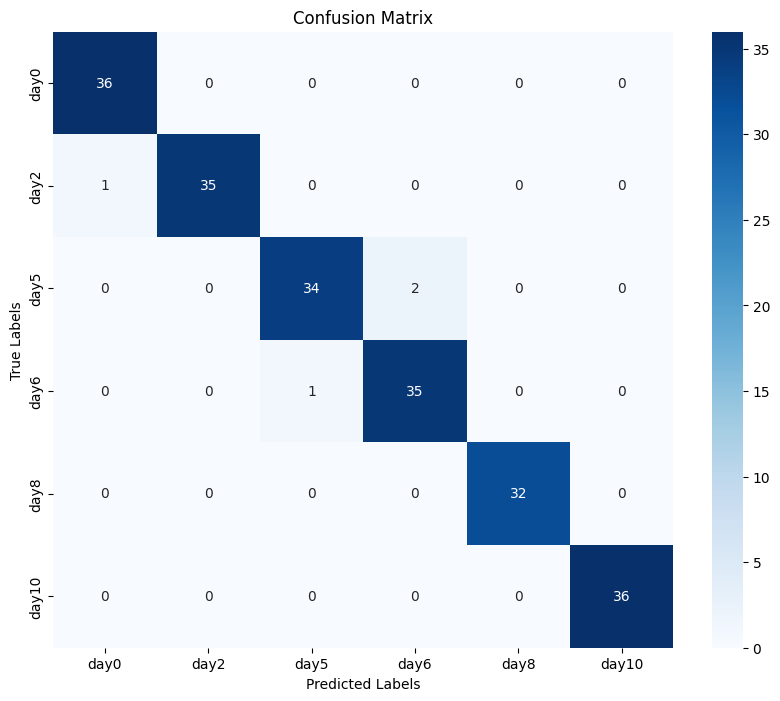

In [ ]:
# Pick a fold for analysis
fold_number = 5
_, val_idx = folds[fold_number - 1]
val_images_fold4 = images[val_idx]
val_labels_fold4 = labels[val_idx]

# Prepare the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices(val_images_fold4)
val_dataset = val_dataset.map(lambda x: tf.image.resize(tf.image.decode_jpeg(tf.io.read_file(x)), IMAGE_SIZE) / 255.0)
val_dataset = val_dataset.batch(BATCH_SIZE)

# Generate predictions
predictions = model.predict(val_dataset)
predicted_labels = np.argmax(predictions, axis=1)

class_names = ["day0", "day2", "day5", "day6", "day8", "day10"]

# Print classification report
print("Classification Report:")
print(classification_report(val_labels_fold4, predicted_labels, target_names=class_names))

# Confusion matrix
conf_matrix = confusion_matrix(val_labels_fold4, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Saving the model.

In [ ]:
# Path to save the final model
final_model_path = "/content/drive/MyDrive/Model Checkpoints/final_model.keras"

# Save the final model
model.save(final_model_path)
print(f"Final model saved at: {final_model_path}")

Final model saved at: /content/drive/MyDrive/Model Checkpoints/final_model.keras
